In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
helper_path = "../code/"
sys.path.insert(0, helper_path)

In [3]:
from New_MissingValue import MissingValue

In [4]:
# relative path
data_path = "../data/"
data_file_list = ["train.csv","test.csv"]

In [5]:
# load data
data_train = pd.read_csv(data_path + data_file_list[0])
data_test = pd.read_csv(data_path + data_file_list[1])

# data info
print(f'Training text file: {data_train.shape[0]} rows; {data_train.shape[1]} columns')
print(f'Testing text file: {data_test.shape[0]} rows; {data_test.shape[1]} columns')
data_train.head()

Training text file: 27486 rows; 4 columns
Testing text file: 3535 rows; 3 columns


,textID,text,selected_text,sentiment
0,a3d0a7d5ad,Spent the entire morning in a meeting w/ a ven...,my boss was not happy w/ them. Lots of fun.,neutral
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,positive
2,c9e8d1ef1c,says good (or should i say bad?) afternoon! h...,says good (or should i say bad?) afternoon!,neutral
3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,negative
4,bf7473b12d,haha better drunken tweeting you mean?,better,positive


In [6]:
# check if NaNs exist in training data, and acquire their locations
missing_value_finder_train = MissingValue(data_train)
missing_value_finder_train.missing_value_summary(verbose=True)
missing_value_finder_train.missing_value_enumerator()

In column text , we have 1 missing values.
In column selected_text , we have 1 missing values.
textID           fdb77c3752
text                    NaN
selected_text           NaN
sentiment           neutral
Name: 13133, dtype: object


[13133]

In [7]:
# drop this missing row
for obj in missing_value_finder_train.na_index:
    data_train = data_train.drop([obj])

In [8]:
# check again
missing_value_finder_train = MissingValue(data_train)
missing_value_finder_train.missing_value_summary(verbose=True)

No missing value found!


({},
 0,
 textID           0
 text             0
 selected_text    0
 sentiment        0
 dtype: int64)

In [9]:
# check if NaNs exist in test data, and acquire their locations
missing_value_finder_test = MissingValue(data_test)
missing_value_finder_test.missing_value_summary(verbose=True)

No missing value found!


({},
 0,
 textID       0
 text         0
 sentiment    0
 dtype: int64)

Note:
- Missing value check & elimination finished 

# Data Classification

- Classify the data by their features, and save them into separate csv files, named "Positive.csv", "Negative.csv" and "Neutral.csv"

In [10]:
def SentiSeparation(data):
    Positive=data[data['sentiment']=='positive']
    Negative=data[data['sentiment']=='negative']
    Neutral=data[data['sentiment']=='neutral']
    Positive.to_csv(r'../data/Positive.csv')
    Negative.to_csv(r'../data/Negative.csv')
    Neutral.to_csv(r'../data/Neutral.csv')

In [11]:
SentiSeparation(data_train)

# Data Cleaning

Since the data set is too large, running through all the data may take too long. Therefore, only data with feature "positive" is tested at this time.

In [12]:
process_path = "../code/"
sys.path.insert(0, process_path)

In [13]:
from TextPreprocessing import TweetPreprocess
from StaAnalysis import StaA
import nltk

In [14]:
Positive=pd.read_csv("../data/Positive.csv")
Positive=pd.DataFrame(Positive)
Positive.head()

,Unnamed: 0,textID,text,selected_text,sentiment
0,1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,positive
1,4,bf7473b12d,haha better drunken tweeting you mean?,better,positive
2,6,2ab82634d5,had an awsome salad! I recommend getting the S...,had an awsome salad!,positive
3,7,a5a1c996c0,fine! Going to do my big walk today 20 or so ...,fine!,positive
4,8,a182b2638e,Thank a yoou how are you? #TwitterTakeover,Thank,positive


In [32]:
Negative=pd.read_csv("../data/Negative.csv")
Negative=pd.DataFrame(Negative)
Negative.head()

,Unnamed: 0,textID,text,selected_text,sentiment
0,3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,negative
1,5,1915bebcb3,headache wanna see my Julie,headache,negative
2,12,41fd07f670,Miss you my dear,Miss you my dear,negative
3,15,49c7c9c6e2,Today Dan bought me Bio Dome AND the Reality B...,", my tummy is not happy. Boo.",negative
4,16,e6f5e9817d,oo noo thats not good,s not good,negative


In [33]:
Neutral=pd.read_csv("../data/Neutral.csv")
Neutral=pd.DataFrame(Neutral)
Neutral.head()

,Unnamed: 0,textID,text,selected_text,sentiment
0,0,a3d0a7d5ad,Spent the entire morning in a meeting w/ a ven...,my boss was not happy w/ them. Lots of fun.,neutral
1,2,c9e8d1ef1c,says good (or should i say bad?) afternoon! h...,says good (or should i say bad?) afternoon!,neutral
2,9,1dcb6fdb13,Why don't adobe realise no one WANTS to pay fo...,Why don't adobe realise no one WANTS to pay fo...,neutral
3,10,6bff31375d,PRD take a long time to review!,PRD take a long time to review!,neutral
4,11,e1ed43bebe,"_2008 Well, having to revise them! Was to do ...","2008 Well, having to revise them! Was to do s...",neutral


In [46]:
def process_to_csv(process_df, feature, clean_csv_path1,clean_csv_path2):
    """ Ensemble method for processing multiple tweets in dataframe (df)
    Params:
        process_df: the df to be processed
        feature: feature (colunm) of the df, use 'text' or 'selected_text'
        clean_csv_path: directory of written out csv file
    Return:
        saved_csv: csv file save to clean_csv_path
    """
    # copy the processed df from original df 
    processed_df = process_df.copy()
    processed_df_tbused=process_df.copy()
    
    for i, tweet in enumerate(process_df[feature]):
        if type(tweet) == str:
            processer = TweetPreprocess(tweet)
        else:
            raise Exception('The tweet must be str!')
            
        # call the processer class 
        clean_tweet_both = processer.process_tweet()
        clean_tweet=clean_tweet_both[0]
        clean_word=clean_tweet_both[1]
        processed_df[feature][i] = clean_tweet
        processed_df_tbused[feature][i]=clean_word
        
    # save as a csv file
    
    #processed_df.to_csv(clean_csv_path1)
    #processed_df_tbused.to_csv(clean_csv_path2)
    return processed_df_tbused


In [37]:
# saving path of the cleaned data
save1='../data/Negative_clean_data.csv'
save2='../data/Negative_clean_data_2bused.csv'
# featured data to be cleaned
feature='selected_text'
# apply the previous function
selected_text=process_to_csv(Negative,feature,save1,save2)
selected_text.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Unnamed: 0,textID,text,selected_text,sentiment
0,3,f14f087215,i dont think you can vote anymore! i tried,"[i, dont, think, you, can, vote, anymore]",negative
1,5,1915bebcb3,headache wanna see my Julie,[headache],negative
2,12,41fd07f670,Miss you my dear,"[miss, you, my, dear]",negative
3,15,49c7c9c6e2,Today Dan bought me Bio Dome AND the Reality B...,"[my, tummy, is, not, happy, boo]",negative
4,16,e6f5e9817d,oo noo thats not good,"[s, not, good]",negative


In [38]:
# saving path of the cleaned data
save1='../data/Neutral_clean_data.csv'
save2='../data/Neutral_clean_data_2bused.csv'
# featured data to be cleaned
feature='selected_text'
# apply the previous function
selected_text=process_to_csv(Neutral,feature,save1,save2)
selected_text.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Unnamed: 0,textID,text,selected_text,sentiment
0,0,a3d0a7d5ad,Spent the entire morning in a meeting w/ a ven...,"[my, boss, was, not, happy, them, lots, of, fun]",neutral
1,2,c9e8d1ef1c,says good (or should i say bad?) afternoon! h...,"[says, good, or, should, i, say, bad, afternoon]",neutral
2,9,1dcb6fdb13,Why don't adobe realise no one WANTS to pay fo...,"[why, do, nt, adobe, realise, no, one, wants, ...",neutral
3,10,6bff31375d,PRD take a long time to review!,"[prd, take, a, long, time, to, review]",neutral
4,11,e1ed43bebe,"_2008 Well, having to revise them! Was to do ...","[well, having, to, revise, them, was, to, do, ...",neutral


In [47]:
# saving path of the cleaned data
save1=1
save2=2
# featured data to be cleaned
feature='selected_text'
# apply the previous function
selected_text=process_to_csv(Positive,feature,save1,save2)
selected_text.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Unnamed: 0,textID,text,selected_text,sentiment
0,1,251b6a6766,Oh! Good idea about putting them on ice cream,[good],positive
1,4,bf7473b12d,haha better drunken tweeting you mean?,[better],positive
2,6,2ab82634d5,had an awsome salad! I recommend getting the S...,"[had, an, awsome, salad]",positive
3,7,a5a1c996c0,fine! Going to do my big walk today 20 or so ...,[fine],positive
4,8,a182b2638e,Thank a yoou how are you? #TwitterTakeover,[thank],positive


# Preparation for Statistical Analysis -- Unigram/Multi-gram

Cleaned data are used to do statistical analysis. Due to the large size of the data to be processed, only first 50 sets of data are tested to verify the code.

In [48]:
split_selected_text=selected_text['selected_text']
split_selected_word=[]
for i in range(len(split_selected_text)):
    for j in split_selected_text[i]:
        split_selected_word.append(j)

check if unigram works, N=1

In [49]:
split_selected_word

['good',
 'better',
 'had',
 'an',
 'awsome',
 'salad',
 'fine',
 'thank',
 'have',
 'just',
 'bought',
 'a',
 'tv',
 'tuner',
 'for',
 'my',
 'laptop',
 'he',
 'he',
 'i',
 'deserve',
 'a',
 'present',
 'happy',
 'birthday',
 'little',
 'sister',
 'of',
 'mine',
 'aaww',
 'no',
 'worries',
 'glad',
 'mp',
 'me',
 'cute',
 'o',
 'quite',
 'like',
 'lily',
 'allen',
 'and',
 'her',
 'music',
 'to',
 'be',
 'honest',
 'i',
 'm',
 'soo',
 'happy',
 'de',
 'that',
 'would',
 'be',
 'most',
 'welcome',
 'happy',
 'aw',
 'that',
 's',
 'cute',
 'so',
 'good',
 'glad',
 'you',
 'finally',
 'got',
 'to',
 'see',
 'them',
 'have',
 'a',
 'great',
 'day',
 'everyone',
 'today',
 'seems',
 'like',
 'it',
 'should',
 'be',
 'a',
 'good',
 'day',
 'love',
 'nice',
 'hall',
 'no',
 'i',
 'was',
 'gutted',
 'when',
 'he',
 'was',
 'nt',
 'lmao',
 'i',
 'think',
 'i',
 'm',
 'obsessed',
 'with',
 'him',
 'bahaha',
 'good',
 'person',
 'hoping',
 'e',
 'nice',
 'how',
 'exciting',
 'had',
 'a',
 'good'

In [50]:
# Timing the process of data clean
import time
start=time.time()
uni_gram,uni_presence,uni_frequency,uni_number_unique_term,uniuni_gram=StaA.nGram(split_selected_word,split_selected_text,1)
frequency,presence,rank=StaA.ranking(uni_frequency,uni_presence,uni_gram)
end=time.time()
print(end-start)

Unigram text framework
756.2335059642792


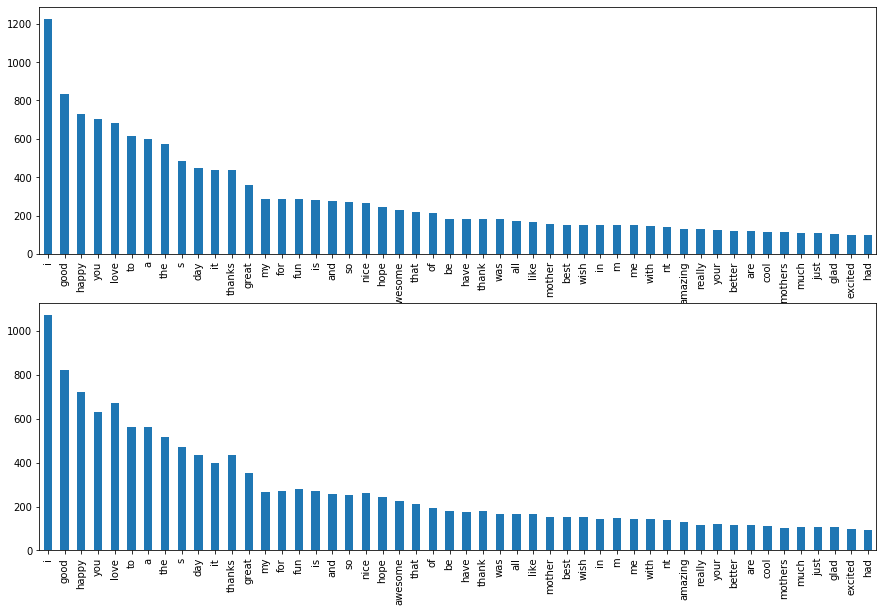

In [60]:
# high frequency word
plt.subplot(2,1,1)
frequency.head(50).plot.bar(figsize=(15,10))
plt.subplot(2,1,2)
presence.head(50).plot.bar(figsize=(15,10))

presence.to_csv('../data/Positive/presence_of_unigram.csv')
frequency.to_csv('../data/Positive/frequency_of_unigram.csv')

In [20]:
print(presence)

i          62.0
happy      51.0
good       47.0
you        36.0
love       38.0
           ... 
realize     1.0
effects     1.0
hooray      1.0
drinks      1.0
waz         1.0
Name: presence, Length: 611, dtype: float64


In [21]:
print(frequency)

i          69
happy      51
good       47
you        40
love       39
           ..
realize     1
effects     1
hooray      1
drinks      1
waz         1
Name: frequency, Length: 611, dtype: int64


In [23]:
bi_gram,bi_presence,bi_frequency,bi_number_unique_term,bibi_gram=StaA.nGram(split_selected_word,split_selected_text,2)

2-gram text frame work


In [24]:
print(bi_presence)

[1. 1. 1. ... 1. 1. 1.]


In [25]:
frequency,presence,ranking=StaA.ranking(bi_frequency,bi_presence,bi_gram)

In [26]:
print(ranking)

                frequency  presence
i love                 12       1.0
i m                    10       1.0
mothers day             9       1.0
happy mothers           9       1.0
i wish                  7       1.0
...                   ...       ...
monday morning          1       1.0
please prays            1       2.0
fun tweets              1       1.0
good lord               1       1.0
hey thanks              1       1.0

[1032 rows x 2 columns]


check if multi-gram works, N=4

In [28]:
tert_gram,tert_presence,tert_frequency,tert_number_unique_term,terttert_gram=StaA.nGram(split_selected_word,split_selected_text,4)

4-gram text frame work


In [29]:
frequency,presence,ranking=StaA.ranking(tert_frequency,tert_presence,tert_gram)

In [31]:
print(frequency)

happy mother s day           7
happy mothers day to         2
that s a great               2
i m obsessed with            1
mothers day to all           1
                            ..
quot office space quot       1
junction with the coolest    1
should be a good             1
that would be most           1
works its whack well         1
Name: frequency, Length: 729, dtype: int64


# Numerify the Text Output of 'Sentiment'

In [ ]:
sentiment=pd.get_dummies(data_train['sentiment'])
print(sentiment)

Assigning sentiment information with values.

In [ ]:
from nltk import FreqDist
import pickle
import sys
import utils

In [ ]:
from collections import Counter